# Context-sensitive Spelling Correction

The goal of the assignment is to implement context-sensitive spelling correction. The input of the code will be a set of text lines and the output will be the same lines with spelling mistakes fixed.

Submit the solution of the assignment to Moodle as a link to your GitHub repository containing this notebook.

Useful links:
- [Norvig's solution](https://norvig.com/spell-correct.html)
- [Norvig's dataset](https://norvig.com/big.txt)
- [Ngrams data](https://www.ngrams.info/download_coca.asp)

Grading:
- 60 points - Implement spelling correction
- 20 points - Justify your decisions
- 20 points - Evaluate on a test set


## Implement context-sensitive spelling correction

Your task is to implement context-sensitive spelling corrector using N-gram language model. The idea is to compute conditional probabilities of possible correction options. For example, the phrase "dking sport" should be fixed as "doing sport" not "dying sport", while "dking species" -- as "dying species".

The best way to start is to analyze [Norvig's solution](https://norvig.com/spell-correct.html) and [N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

When solving this task, we expect you'll face (and successfully deal with) some problems or make up the ideas of the model improvement. Some of them are: 

- solving a problem of n-grams frequencies storing for a large corpus;
- taking into account keyboard layout and associated misspellings;
- efficiency improvement to make the solution faster;
- ...

Please don't forget to describe such cases, and what you decided to do with them, in the Justification section.

##### IMPORTANT:  
Your project should not be a mere code copy-paste from somewhere. You must provide:
- Your implementation
- Analysis of why the implemented approach is suggested
- Improvements of the original approach that you have chosen to implement

## Justify your decisions

Write down justificaitons for your implementation choices. For example, these choices could be:
- Which ngram dataset to use
- Which weights to assign for edit1, edit2 or absent words probabilities
- Beam search parameters
- etc.

*Your text here...*

## Evaluate on a test set

Your task is to generate a test set and evaluate your work. You may vary the noise probability to generate different datasets with varying compexity (or just take another dataset). Compare your solution to the Norvig's corrector, and report the accuracies.

#### Useful resources (also included in the archive in moodle):

1. [Possible dataset with N-grams](https://www.ngrams.info/download_coca.asp)
2. [Damerau–Levenshtein distance](https://en.wikipedia.org/wiki/Damerau–Levenshtein_distance#:~:text=Informally%2C%20the%20Damerau–Levenshtein%20distance,one%20word%20into%20the%20other.)

# Solution:

To implement this assignment and both improve provided baseline in term of metric (accuracy) I've decided to take Rust as main programming language, because: 
- it is fast (comparable and sometimes faster than C lang due to compiler optimisations)
- does not have GIL -> can be parralelized via multithreading
- Rust code can be easily adapted for python 

90% if implementation of this assignment is written in rust, but as you can see in further cells, we can use/run that code as it is written in python, so you can rely on method names. **But you can also find the implementation in the spelling_corrector/src/lib.rs file.**

### Implementation details: 
Implementation consists of 2 main parts: 
1) Levenshtain distance (string_distance in rust impl.): 
    I have implemented it as in a wiki page describing this algorithm, so just O(m x n) time complexity. 
    There also been tried the Damerau-Levenshtain distance, but it performed a bit worse.

2) Spelling correction system that implements many methods for searching similar words: <br>
        **Fields:** <br>
        n_grams <br> 
        stores all sizes of ngrams, that passed by user, can be threated as hyperparameter <br><br>
        n_grams_map <br> 
        stores all ngrams found in train dataset <br> <br>
        word_to_index <br> 
        converts each known word to its unique index, helps save memory <br> <br>
        index_to_word <br> 
        converts index to word's string representation <br><br>
        coocurrence_matrix <br> 
        keeps track of counts of 2 words occur in the same context, context is defined as in word2vec (window of some size) <br> <br>
        context_window <br> 
        defines context window size <br> <br>
        occurences <br> 
        keeps number of times of each word occured in train dataset <br> <br>

    **Methods:** 
            get_search_space: <br>
            takes: word, number of candidates to return, word context <br>>
            If word presents in the system, then it returns it. But if it is not, the following pipeline applied: <br>
            - build word ngrams<br>
            - get all words that has such ngrams<br>
            - compute string distances with original word<br>
            - compute probability of occuring candidate in context by $P(word|context) = \frac{\sum{word \&}{context\_word_i}}{word\_counts}$<br>  
            - return N (passed as parameter) candidate words and their fit score, then I select top 1 of them

    Under the hood there are many parralel operations to make it work fast, and some other optimisations, for example: if the candidate differs too much from misspelled word, we simply ignore context, as computing it costs O(dictionary) operations. 

Fethcing...
Fetched.
Preproces...
Done.
Words extracted: 1067521


Text(0.5, 1.0, 'Words len distriubution')

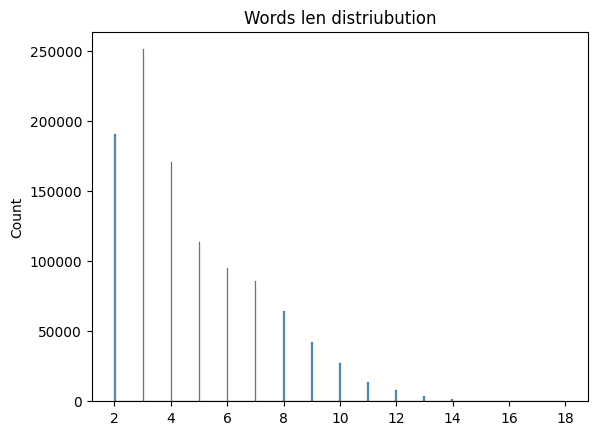

In [1]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt


print('Fethcing...')
raw_data = requests.get('https://norvig.com/big.txt').text
print('Fetched.\nPreproces...')
data = raw_data.lower()
# remove punkt
data = map(lambda x: x if (x.isalpha() or x.isspace()) else " ", data)
# collect symbols
data = "".join(data).split()
# extract words, filter out 1 letter words
data = list(filter(lambda x: len(x) > 1, data))
print(f'Done.\nWords extracted: {len(data)}')
sns.histplot(list(map(len, data)))
plt.title('Words len distriubution')

#### Interface to interact with system is adapdet to python 

In [2]:
from spelling_corrector import SpellingCorrectionSystem


system = SpellingCorrectionSystem(n_grams=[1, 2, 3, 4, 5, 6], 
                                                                dictionary=data,  
                                                                context_window=5)

In [3]:
def test(spelling_corrector, dataset: list[dict['correct': str, 'misspelled': str, 'context': list[str]]]): 
    correct = 0
    
    for pair in dataset:
        responce = spelling_corrector.get_search_space(pair['misspelled'], 30, context=pair['context']) 
        correction = sorted(map(lambda x: x, responce), key=lambda x: x[1][1] * (len(x[0]) - x[1][0]), reverse=True)
        
        if correction[0][0] == pair['correct']:
            correct += 1
            
    return correct / len(dataset)  * 100

#### Preparing the test dataset & enrichment with context

In [4]:
from time import time

def get_dataset(filename): 
    test_dataset: list[dict['correct': str, 'misspelled': str]] = [] 
    with open(filename) as file: 
        for line in file.readlines(): 
            correct, misspells = line.split(':')
            
            for misspelled in misspells.split():
                context_words = [word for word, stat in system.get_context(correct.strip())] 
                
                test_dataset.append({
                    'correct': correct.strip(), 
                    'misspelled': misspelled.strip(), 
                    'context': context_words,
                })
        return test_dataset

#### Evaluation on eval dataset

In [5]:
val_dataset = get_dataset('spell-testset1.txt')

wps = [] 
for _ in range(5):
    s = time()
    score = test(system, val_dataset)
    e = time()
    wps.append(len(val_dataset) / (e - s))

print(f'{score = }')
print(f'wps = {round(max(wps), 2)}')

score = 90.74074074074075
wps = 252.56


#### Evaluation on test dataset

In [6]:
test_dataset = get_dataset('spell-testset2.txt')

wps = [] 
for _ in range(5):
    s = time()
    score = test(system, test_dataset)
    e = time()
    wps.append(len(test_dataset) / (e - s))

print(f'{score = }')
print(f'wps = {round(max(wps), 2)}')

score = 82.25
wps = 239.03


### Results

My implementation of the system achieved 90.7% accuracy score on the validation dataset and 82.0%, while baseline has 75% and 68% respectively. Also, the running time is 6-8~ times faster. As baseline can work at 35-41 words per second, while my solution works on 239-252 wps.

In the test_performance.ipynb file you can also find my experiments of implementing & testing Damerau-Levenshtain distance in Python, Rust in C adapted to be called from python code. Their implementation is in the damerau_c & spelling_corrector repository folders.  